In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats
from itertools import product
import warnings

%matplotlib inline

In [2]:
data = pd.read_csv("WAG_C_M.csv", sep = ';', index_col = ['month'],
                   parse_dates = ['month'], dayfirst = True)

In [3]:
data.columns= ['wage']

In [4]:
data.describe()

,wage
count,284.000000
mean,12193.308099
std,11992.326701
min,15.300000
25%,1191.000000
50%,7195.000000
75%,21365.250000
max,43408.000000


# Визуальный анализ ряда

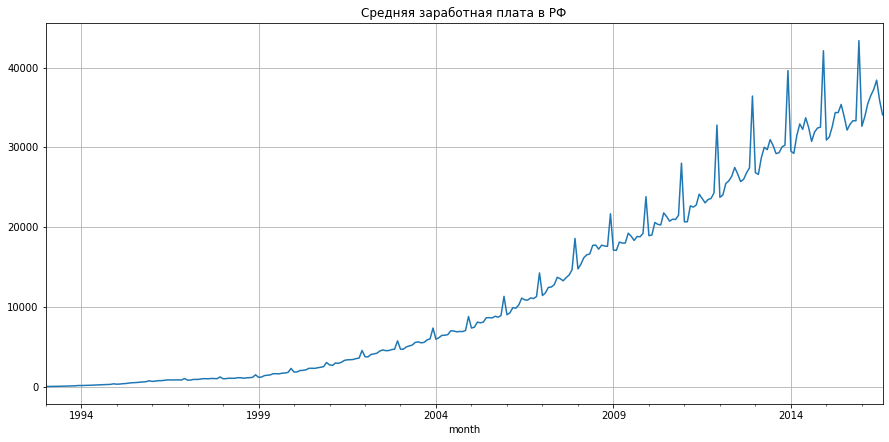

In [5]:
plt.figure(figsize=(15,7))
data.wage.plot()
plt.title("Средняя заработная плата в РФ")
plt.grid()
plt.show()

<Figure size 1080x720 with 0 Axes>

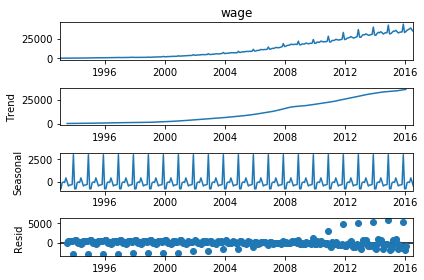

In [6]:
plt.figure(figsize=(15,10))
fig = sm.tsa.seasonal_decompose(data.wage).plot()

In [7]:
print("Критерий Дики-Фуллера:", sm.tsa.stattools.adfuller(data.wage)[1])

Критерий Дики-Фуллера: 0.9918495954854737


Поскольку критерий Дики-Фуллера больше 0.05, гипотеза о стационарности ряда отвергается

# Стабилизация дисперсии

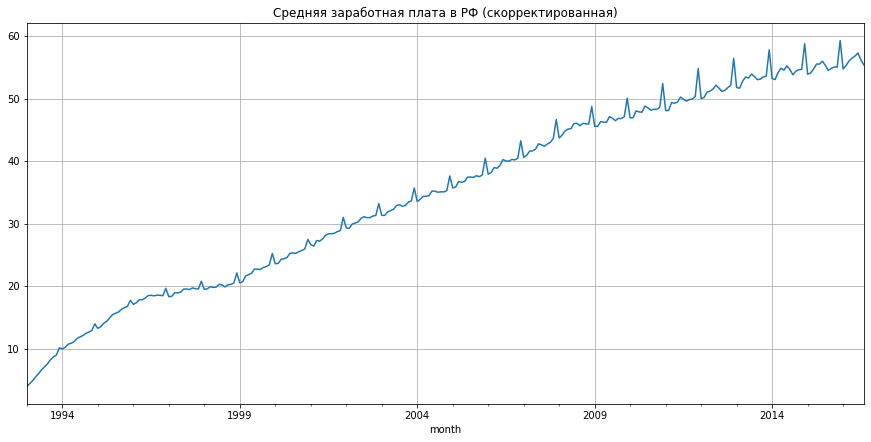

lambda = 0.26


In [8]:
data['box_cox'], lmbda = stats.boxcox(data.wage)
plt.figure(figsize=(15,7))
data.box_cox.plot()
plt.title("Средняя заработная плата в РФ (скорректированная)")
plt.grid()
plt.show()

print("lambda = %.2f" %lmbda)

In [9]:
print("Критерий Дики-Фуллера:", sm.tsa.stattools.adfuller(data.box_cox)[1])

Критерий Дики-Фуллера: 0.6968987634832663


# Выбор порядка дифференцирования

In [10]:
data['season_diff'] = data.box_cox - data.box_cox.shift(12)

Критерий Дики-Фуллера: 0.014697133494791917


<Figure size 1080x504 with 0 Axes>

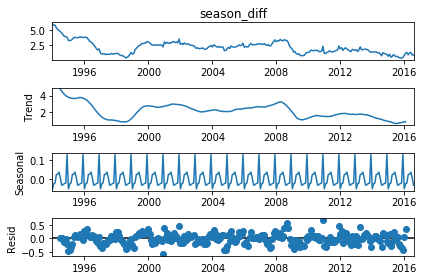

In [11]:
plt.figure(figsize=(15,7))
sm.tsa.seasonal_decompose(data.season_diff.dropna()).plot()
print("Критерий Дики-Фуллера:", sm.tsa.stattools.adfuller(data.season_diff.dropna())[1])

In [12]:
data['diff_1'] = data.season_diff - data.season_diff.shift(1)

Критерий Дики-Фуллера: 5.203603715821573e-08


<Figure size 1080x720 with 0 Axes>

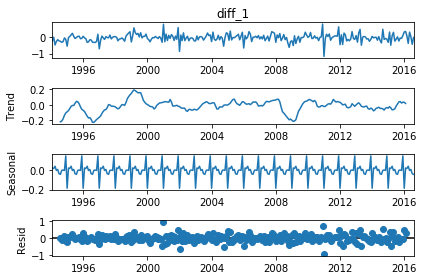

In [13]:
plt.figure(figsize=(15,10))
sm.tsa.seasonal_decompose(data.diff_1.dropna()).plot()
print("Критерий Дики-Фуллера:", sm.tsa.stattools.adfuller(data.diff_1.dropna())[1])

Согласно критерию Дики-Фуллера, ряд стационарен

# Выбор начальных приближений для p, q, P, Q

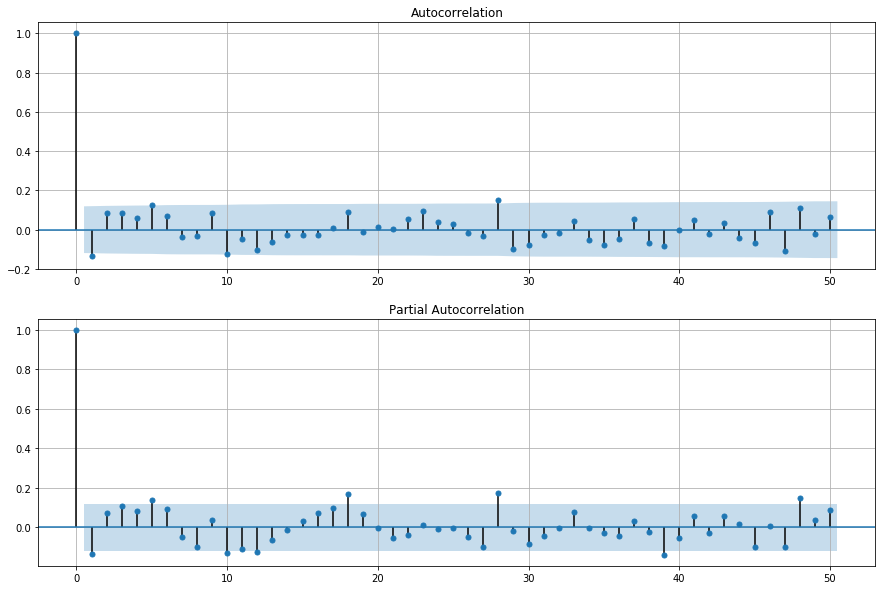

In [14]:
plt.figure(figsize=(15,10))
ax = plt.subplot(2, 1, 1)
sm.graphics.tsa.plot_acf(data.diff_1.dropna().values.squeeze(), lags = 50, ax = ax)
plt.grid()
ax = plt.subplot(2, 1, 2)
pacf = sm.graphics.tsa.plot_pacf(data.diff_1.dropna().values.squeeze(), lags = 50, ax = ax)
plt.grid()

Q = 0, q = 1

P = 1, p = 1

In [15]:
Q = range(0, 1)
q = range(0, 2)
P = range(0, 2)
p = range(0, 2)
d = 1
D = 1

In [16]:
param = list(product(p, q, P, Q))

In [17]:
warnings.filterwarnings('ignore')
res = []
min_aic = float('inf')

for i in param:
    try:
        model = sm.tsa.statespace.SARIMAX(data.box_cox, order = (i[0], d, i[1]),
                            seasonal_order = (i[2], D, i[3], 12)).fit()
    except ValueError:
        continue
    aic = model.aic
    if aic < min_aic:
        min_aic = aic
        best_model = model
    res.append([i, aic])
    
warnings.filterwarnings('default')
    
res = pd.DataFrame(res)
res.columns = [ 'param', 'aic']
res.sort_values(by = 'aic')

,param,aic
5,"(1, 0, 1, 0)",0.340521
3,"(0, 1, 1, 0)",1.170768
7,"(1, 1, 1, 0)",2.021912
4,"(1, 0, 0, 0)",2.625709
2,"(0, 1, 0, 0)",3.369832
6,"(1, 1, 0, 0)",4.003439
1,"(0, 0, 1, 0)",4.268898
0,"(0, 0, 0, 0)",5.241225


In [18]:
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                            box_cox   No. Observations:                  284
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                   2.830
Date:                            Thu, 27 Aug 2020   AIC                              0.341
Time:                                    21:53:37   BIC                             11.147
Sample:                                01-01-1993   HQIC                             4.679
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1488      0.046     -3.210      0.001      -0.240      -0.058
ar.S.L12      -0.1314      0.046     -2.838      0.005      -0.222      -0.041
sigma2         0.0573      0.004     15.137      0.000       0.050       0.065
===================================================================================
Ljung-Box (Q):                       55.80   Jarque-Bera (JB):                55.20
Prob(Q):                              0.05   Prob(JB):                         0.00
Heteroskedasticity (H):               1.39   Skew:                             0.11
Prob(H) (two-sided):                  0.12   Kurtosis:                         5.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Анализ остатков построенной модели

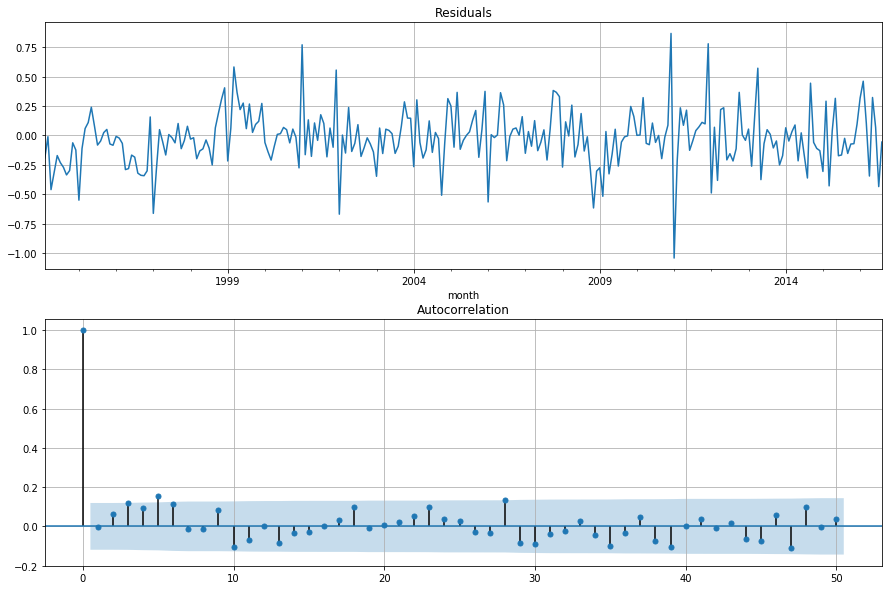

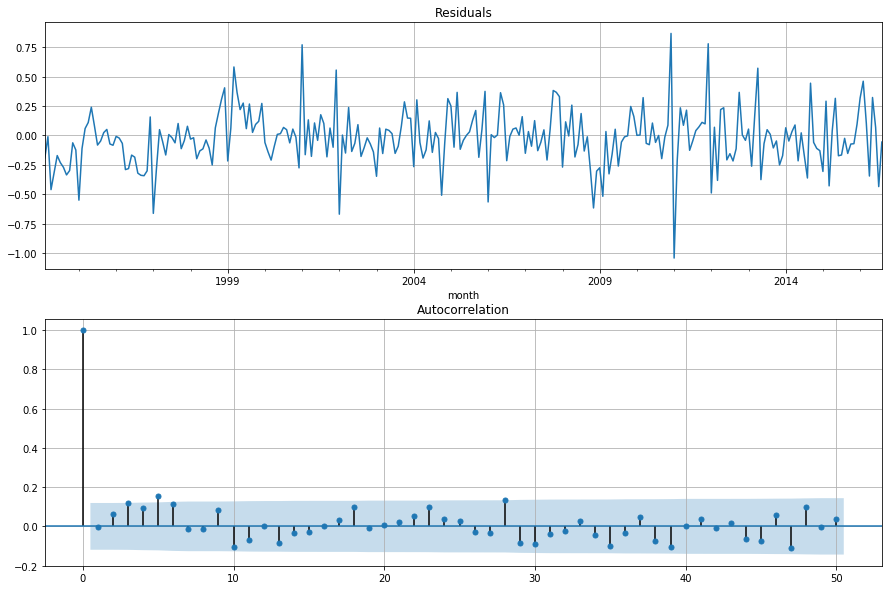

In [19]:
plt.figure(figsize=(15,10))

plt.subplot(2, 1, 1)
plt.title('Residuals')
best_model.resid[13:].plot()
plt.grid()

ax = plt.subplot(2, 1, 2)
plt.grid()
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=50, ax=ax)

In [20]:
print("Критерий Стьюдента: ", stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: ", sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Критерий Стьюдента:  0.09079310495225511
Критерий Дики-Фуллера:  3.459291348870084e-06


остатки стационарны, без смещения и автокорреляции

# Прогнозирование с помощью финальной модели

In [21]:
def inv_box_cox(y, lmbda):
    if lmbda == 0:
        return np.exp(y)
    else:
        return np.exp(np.log(lmbda * y + 1) / lmbda)

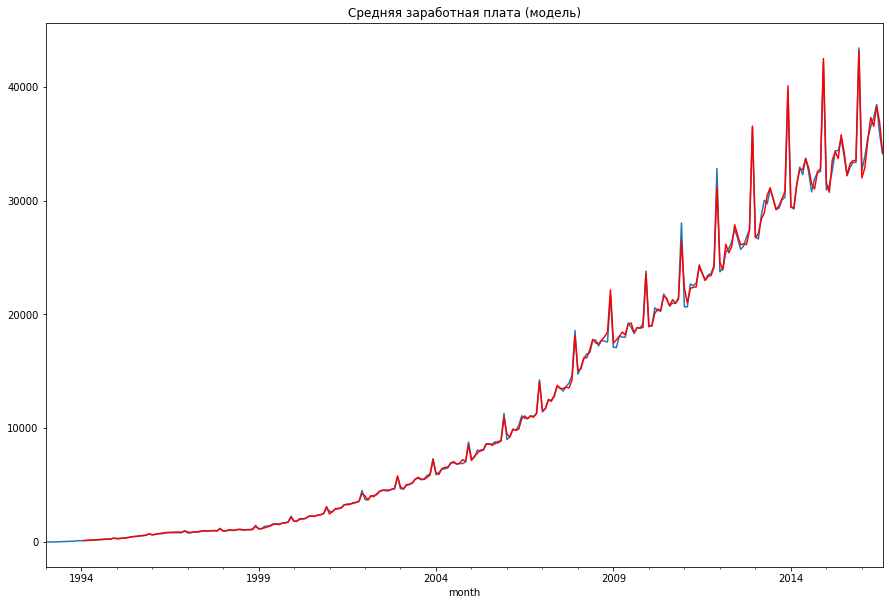

In [22]:
data['model'] = inv_box_cox(best_model.fittedvalues, lmbda)
plt.figure(figsize = (15,10))
plt.title('Средняя заработная плата (модель)')
data.wage.plot()
data.model[13:].plot(color='red')
plt.show()

In [23]:
start = len(data.wage) - 1
predict = inv_box_cox(best_model.predict(start = start, end = start + 36), lmbda)
predict = pd.DataFrame(predict)
predict.columns = ['forecast']
result = pd.concat([data, predict])

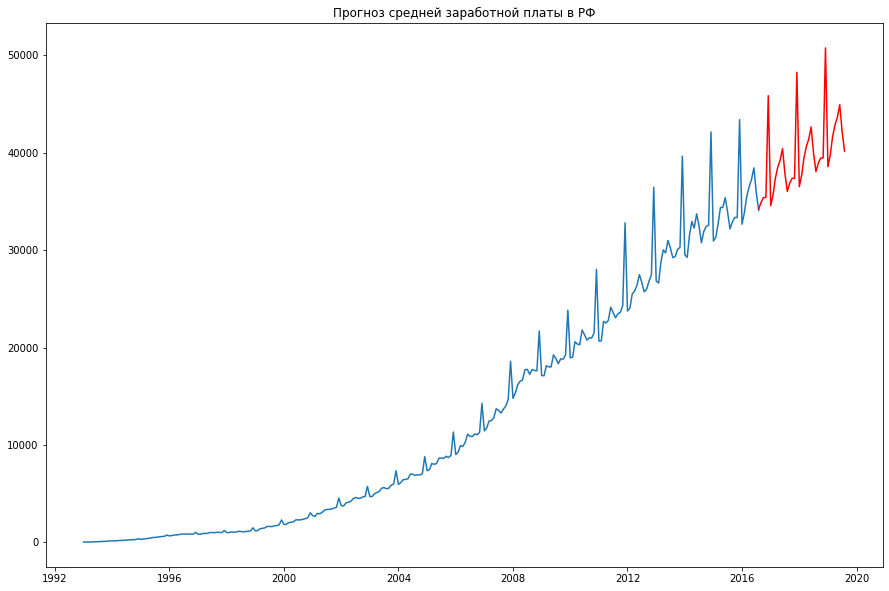

In [24]:
plt.figure(figsize = (15, 10))
plt.title("Прогноз средней заработной платы в РФ")
plt.plot(result.wage.dropna())
plt.plot(result['forecast'].dropna(), color = 'red')